In [2]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psycopg2 
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

In [3]:
# set pandas options 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# csv repo
data_source = 'data_csv'

# establish URL for connection to the database 
url_object = URL.create(
    "postgresql+psycopg2",
    username="postgres",
    password="Ee123456!",
    host="localhost",
    database="Masters:Programing_with_python",
)

# set matplotlib style
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
data_source = 'data_csv'

__margin = np.sqrt(2)

### probably will be some class properties

In [10]:
class CSVReadError(Exception):
    def __init__(self, message='Error reading CSV file'):
        self.message = message
        super().__init__(self.message)

In [26]:
class Colors:
    def __init__(self):
        self.__color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        self.current_index = 0
        
    @property
    def next_color(self):
        color = self.__color_cycle[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.__color_cycle)
        return color
    
    @property
    def reset(self):
        self.current_index = 0


class CSVToDataBase:
    def __init__(self, csv_name, csv_source, db_name, db_url):
        self.csv_name = csv_name
        self.db_name = db_name
        self.url = db_url
        self.csv_source = csv_source
        self.col_names = list()

    def rename_columns(self, col_names):
        self.col_names = col_names    

    def _create_table(self, engine):
        df = pd.read_csv(os.path.join(self.csv_source, self.csv_name))
        if self.col_names:
            df.columns = self.col_names           
        df.to_sql(self.db_name, engine, if_exists='replace', index=False)

    def create(self):
        engine = create_engine(self.url, pool_pre_ping=True)
        self._create_table(engine)
        print(f'Database "{self.db_name}" was created!')


class CustomDF(pd.DataFrame):
    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)
    
    @property
    def _constructor(self):
        return CustomDF
    
    @classmethod
    def read_sql_query(cls, query, url, *args, **kwargs):
        """
        Read SQL query into a CustomDF object.
        Returns a table of data corresponding to the result of the query string.
        
        Parameters
        ----------
        query: str; SQL query to be executed.
        url: sqlalchemy.engine.URL object /..add../
        
        Returns
        -------
        Returns a CustomDF object that contains the result set of the
        executed SQL query, in relation to the specified database connection.
        """
        engine = create_engine(url, pool_pre_ping=True)
        with engine.connect() as conn:
            return pd.read_sql_query(text(query), con=conn, *args, **kwargs) 
    
    @classmethod 
    def read_by_lines(cls, file_name, data_source):
        """
        Read CSV file line by line into a CustomDF object.
        
        Parameters
        ----------
        file_name: str
            Name of the CSV file.
        data_source: str | os.path object, optional
            Corresponding to the path to the directory with CSV files.
        
        Returns
        -------
        CustomDF
            A custom DataFrame object containing the result set of the data from the CSV file.
        """
        try:
            file_path = os.path.join(data_source, file_name)
            rows = []
            
            # read CSV file line by line
            with open(file_path, 'r') as file:
                columns = file.readline().strip().split(',')
                # init CustomDF object 
                df = cls(columns=columns)
                
                # iter trought lines
                for line in file:
                    values = line.strip().split(',')
                    rows.append(values)
                
                # add file data to CustomDF object    
                df = pd.concat([df, CustomDF(rows, columns=df.columns)], ignore_index=True)
            return df

        except Exception as e:
            raise CSVReadError(f'Error reading CSV file: {str(e)}')
            
    @classmethod 
    def read_by_lines(cls, file_name, data_source):


# Converting and Load data
## First will create databases 
According to the task:  Your Python program needs to be able to
independently compile a SQLite database (file) ideally via sqlalchemy and load the training data into a single fivecolumn spreadsheet/table in the file. Its first column depicts the x-values of all functions. The fifty ideal functions, which are also
provided via a CSV-file, must be loaded into another table. Likewise, the first column depicts the x-values,
meaning there will be 51 columns overall. 

In [96]:
db_creator = CSVToDataBase('train.csv', data_source, 'The training data', url_object)
db_creator.rename_columns(['X'] + [f'Y{i}(training func)' for i in range(1, 5)])
db_creator.create()

Database "The training data" was created!


In [6]:
db_creator = CSVToDataBase('ideal.csv', data_source, 'The ideal functions', url_object)
db_creator.rename_columns(['X'] + [f'Y{i}(ideal func)' for i in range(1, 51)])
db_creator.create()

Database "The ideal functions" was created!


## Read train and ideal from database

In [32]:
train = CustomDF.read_sql_query('SELECT * FROM "The training data"', url_object)
ideal = CustomDF.read_sql_query('SELECT * FROM "The ideal functions"', url_object)

## Read test data from csv file line by line

In [33]:
test = CustomDF.read_by_lines('test.csv', data_source)

In [34]:
train.shape, ideal.shape, test.shape

((400, 5), (400, 51), (100, 2))

In [9]:
(ideal['X'] == train['X']).all() # test case 

True

In [35]:
(test['X'].isin(ideal['X'])).all() # test case 

KeyError: 'x'

In [ ]:
features = ideal['x']
train_lables = train.drop(columns=['x'])
ideal_lables = ideal.drop(columns=['x'])

In [12]:
diff_train1 = pd.DataFrame.from_dict({'reference': train_lables['y1']})
diff_train2 = pd.DataFrame.from_dict({'reference': train_lables['y2']})
diff_train3 = pd.DataFrame.from_dict({'reference': train_lables['y3']})
diff_train4 = pd.DataFrame.from_dict({'reference': train_lables['y4']})

In [13]:
%%timeit
for (ideal_name, ideal_lable) in ideal_lables.iteritems():
    diff_train1[f'sq_dif_{ideal_name}'] = np.power((diff_train1['reference'] - ideal_lable), 2)
    diff_train2[f'sq_dif_{ideal_name}'] = np.power((diff_train2['reference'] - ideal_lable), 2)
    diff_train3[f'sq_dif_{ideal_name}'] = np.power((diff_train3['reference'] - ideal_lable), 2)
    diff_train4[f'sq_dif_{ideal_name}'] = np.power((diff_train4['reference'] - ideal_lable), 2)

60.8 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
diff_train1.head()

,reference,sq_dif_y1,sq_dif_y2,sq_dif_y3,sq_dif_y4,sq_dif_y5,sq_dif_y6,sq_dif_y7,sq_dif_y8,sq_dif_y9,sq_dif_y10,sq_dif_y11,sq_dif_y12,sq_dif_y13,sq_dif_y14,sq_dif_y15,sq_dif_y16,sq_dif_y17,sq_dif_y18,sq_dif_y19,sq_dif_y20,sq_dif_y21,sq_dif_y22,sq_dif_y23,sq_dif_y24,sq_dif_y25,sq_dif_y26,sq_dif_y27,sq_dif_y28,sq_dif_y29,sq_dif_y30,sq_dif_y31,sq_dif_y32,sq_dif_y33,sq_dif_y34,sq_dif_y35,sq_dif_y36,sq_dif_y37,sq_dif_y38,sq_dif_y39,sq_dif_y40,sq_dif_y41,sq_dif_y42,sq_dif_y43,sq_dif_y44,sq_dif_y45,sq_dif_y46,sq_dif_y47,sq_dif_y48,sq_dif_y49,sq_dif_y50
0,39.778572,1655.799580,1550.035477,941.969216,1181.330583,2387.849502,1510.536939,1649.792963,1650.755569,1518.069226,463.096068,3573.477670,9560.649142,7187.406270,391.191910,717.091918,129759.477190,193405.192390,577936.619590,137063.905750,62111.320174,6.463804e+07,6.336513e+07,6.336513e+07,2.572745e+08,5.776706e+08,3.447778e+07,1.125344e+08,6.496003e+07,5.836622e+07,7.805331e+07,391.191910,1246.544423,386.278222,1642.274515,886.763350,3626.620390,3573.477670,1689.177063,129102.596735,739278.959006,6437.662607,0.181023,1352.977296,1582.997836,717.320518,1188.887957,2031.925958,1597.189258,1510.536939,1550.920059
1,39.604813,1638.019784,1529.406505,928.570636,1163.330240,2375.311642,1500.568254,1637.822972,1555.221389,1490.766185,499.017339,3540.822770,9468.226633,7124.172458,388.279655,710.479056,127024.657321,189760.265305,566128.613628,134252.761061,60518.552031,6.272963e+07,6.148119e+07,6.148119e+07,2.496654e+08,5.605720e+08,3.334998e+07,1.094922e+08,6.304525e+07,5.661349e+07,7.581575e+07,388.279655,1235.091669,383.359914,1618.071816,882.375915,3587.433426,3540.822770,1678.511639,126406.947327,729158.850262,6374.207319,0.196938,1340.591821,1569.201913,708.309946,1177.279581,2015.841000,1585.672473,1500.568254,1530.989354
2,40.099070,1673.852600,1561.652420,955.597742,1191.474948,2429.050259,1543.342360,1680.037552,1559.197811,1516.045293,575.439976,3587.898587,9506.068651,7173.932459,412.052243,739.789409,123862.418209,186744.175820,553507.624204,131001.236809,58632.229981,6.087887e+07,5.963381e+07,5.963381e+07,2.422656e+08,5.439285e+08,3.226071e+07,1.065051e+08,6.118824e+07,5.491479e+07,7.364336e+07,412.052243,1270.876227,406.958281,1646.315099,918.033643,3469.319555,3587.898587,1721.757480,123290.345693,718018.342554,6416.956176,0.043435,1377.403569,1608.604918,735.135809,1211.792006,2060.010360,1626.958461,1543.342360,1564.197825
3,40.151100,1673.028695,1559.574668,954.975260,1189.660164,2440.313169,1552.322693,1686.091715,1692.974269,1507.908777,642.374297,3582.154171,9457.776451,7148.888511,418.247491,745.350061,121061.478133,183390.439729,541738.541635,128120.256133,56996.262373,5.906728e+07,5.783940e+07,5.783940e+07,2.350364e+08,5.276793e+08,3.119652e+07,1.035950e+08,5.937048e+07,5.325254e+07,7.151584e+07,418.247491,1275.392084,413.089446,1637.621472,927.269491,3404.594131,3582.154171,1727.426677,120539.049056,707750.793306,6388.307266,0.177473,1381.644680,1612.781763,738.235065,1215.770199,2064.275944,1632.078190,1552.322693,1563.274012
4,39.795662,1638.438174,1526.017652,928.885687,1160.374899,2412.155331,1529.881403,1658.614268,1522.662345,1469.410433,698.501291,3527.844664,9330.721917,7055.271235,407.864764,728.765767,118586.797286,179738.403342,530747.711058,125574.084046,55584.823073,5.729478e+07,5.609621e+07,5.609621e+07,2.279758e+08,5.118183e+08,3.015736e+07,1.007594e+08,5.759188e+07,5.162669e+07,6.943308e+07,407.864764,1250.928882,402.745615,1595.419283,911.778004,3387.744962,3527.844664,1698.182645,118117.570074,698282.407071,6294.302764,0.052886,1355.722143,1584.360263,719.319480,1191.461051,2031.645373,1603.606138,1529.881403,1530.981610


In [15]:
MSE = pd.DataFrame()

In [16]:
for idx, frame in enumerate((diff_train1, diff_train2, diff_train3, diff_train4)):
    frame.loc['sum'] = frame.sum()
    MSE[f'train_y{idx+1}'] = frame.loc['sum'] / train.shape[0]

In [17]:
frame.head()

,reference,sq_dif_y1,sq_dif_y2,sq_dif_y3,sq_dif_y4,sq_dif_y5,sq_dif_y6,sq_dif_y7,sq_dif_y8,sq_dif_y9,sq_dif_y10,sq_dif_y11,sq_dif_y12,sq_dif_y13,sq_dif_y14,sq_dif_y15,sq_dif_y16,sq_dif_y17,sq_dif_y18,sq_dif_y19,sq_dif_y20,sq_dif_y21,sq_dif_y22,sq_dif_y23,sq_dif_y24,sq_dif_y25,sq_dif_y26,sq_dif_y27,sq_dif_y28,sq_dif_y29,sq_dif_y30,sq_dif_y31,sq_dif_y32,sq_dif_y33,sq_dif_y34,sq_dif_y35,sq_dif_y36,sq_dif_y37,sq_dif_y38,sq_dif_y39,sq_dif_y40,sq_dif_y41,sq_dif_y42,sq_dif_y43,sq_dif_y44,sq_dif_y45,sq_dif_y46,sq_dif_y47,sq_dif_y48,sq_dif_y49,sq_dif_y50
0,-0.324914,0.345781,0.537284,88.585165,32.867246,76.775111,1.532296,0.264358,0.276681,1.302060,345.358338,387.108999,3326.415516,1995.863287,413.102139,177.553340,160260.036969,159740.174169,640519.968369,168366.535254,83708.906006,6.399480e+07,6.400520e+07,6.400520e+07,2.559896e+08,5.757444e+08,3.400843e+07,1.133868e+08,6.431519e+07,5.775506e+07,7.734631e+07,413.102139,23.011691,418.183042,0.177662,106.603854,10065.088419,387.108999,0.992241,159529.933163,809850.272570,1610.542088,1642.596133,11.026694,0.100223,177.439617,31.620734,24.734739,0.019220,1.532296,0.520943
1,-0.058820,0.654197,0.309142,84.477714,30.869198,82.329058,0.858335,0.650269,0.051682,1.109212,300.153437,393.672429,3322.505647,2001.773200,398.354490,169.229394,156870.510068,156777.337051,627388.856877,164891.886466,81606.674642,6.210291e+07,6.210477e+07,6.210477e+07,2.484135e+08,5.586954e+08,3.289344e+07,1.103239e+08,6.241696e+07,5.601819e+07,7.512660e+07,398.354490,20.428247,403.369220,0.315429,99.178093,9911.958613,393.672429,1.705662,156183.972566,798470.239826,1614.030636,1608.604326,9.299692,0.002548,170.290491,28.645241,27.399835,0.024608,0.858335,0.287054
2,-0.451830,0.130931,1.067402,92.894043,36.398915,76.291427,1.601499,0.191285,1.132566,2.606524,274.318712,374.351698,3243.094112,1949.060950,410.136602,178.271354,154049.836303,153341.295197,615490.191656,161999.672895,79914.670523,6.024772e+07,6.026174e+07,6.026174e+07,2.410049e+08,5.420387e+08,3.180171e+07,1.073438e+08,6.055548e+07,5.431543e+07,7.294903e+07,410.136602,24.025179,415.250356,0.000572,105.100010,9890.666411,374.351698,0.889562,153411.772874,788385.108575,1564.598531,1627.516467,11.816486,0.196677,180.566718,32.948709,23.391127,0.046365,1.601499,1.001918
3,-0.612044,0.019468,1.617205,97.228873,39.334141,74.587091,1.859453,0.089343,0.146401,3.730086,237.715964,364.350057,3190.889150,1917.385073,412.579140,181.226634,151089.279165,150139.166231,603405.879932,158963.320049,78121.392712,5.844237e+07,5.846109e+07,5.846109e+07,2.337882e+08,5.258082e+08,3.074282e+07,1.044264e+08,5.874396e+07,5.265927e+07,7.082806e+07,412.579140,25.507673,417.734007,0.087384,106.338256,9823.197306,364.350057,0.638686,150505.578191,777998.802807,1533.798750,1627.466330,12.907227,0.364442,184.760479,34.753947,21.819730,0.132610,1.859453,1.500341
4,-0.306076,0.141292,1.076327,92.623524,36.450943,81.215430,0.976221,0.389814,1.167332,3.128823,186.938968,372.255519,3191.563494,1926.676599,396.251846,171.769218,147814.163287,147343.835277,590786.044092,155603.484799,76102.091667,5.668930e+07,5.669852e+07,5.669852e+07,2.267664e+08,5.100055e+08,2.971852e+07,1.015661e+08,5.698483e+07,5.105202e+07,6.876638e+07,396.251846,22.403794,401.329687,0.025293,98.130334,9664.084500,372.255519,1.226056,147290.239711,766911.222048,1539.377723,1589.757931,10.768933,0.088634,176.401047,31.183185,24.721176,0.003213,0.976221,0.948632


In [18]:
MSE = MSE.drop(['reference'])
MSE.index = [idx.split('_')[-1] for idx in MSE.index]
MSE.index.name = 'No ideal func'

In [19]:
MSE.head()

,train_y1,train_y2,train_y3,train_y4
No ideal func,,,,
y1,531.472176,534.268865,134.514539,0.552048
y2,532.346369,533.420559,133.876070,0.614010
y3,629.273209,636.107997,235.501458,100.253745
y4,556.725800,559.819042,159.848446,25.943774
y5,636.494906,630.439191,232.010051,100.850119


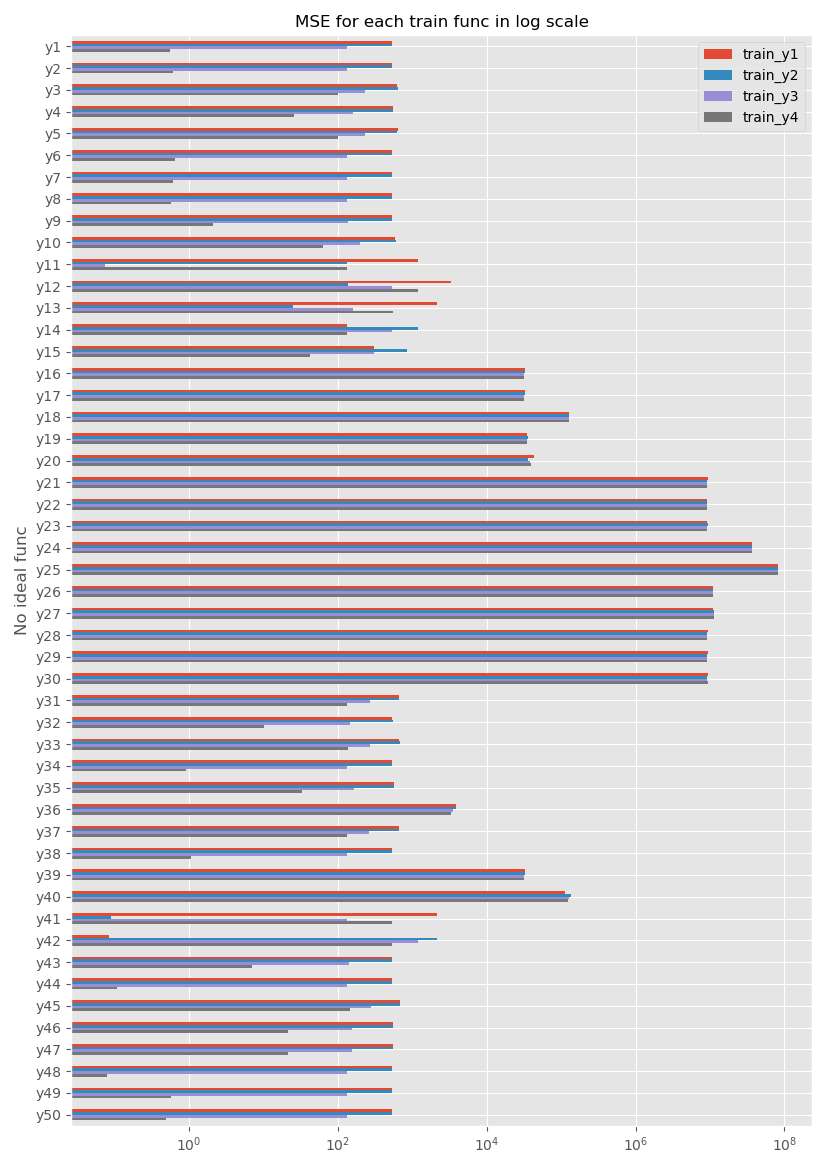

In [20]:
# ploting MSE
ax = MSE.plot(
    figsize=(8.27, 11.69),
    kind='barh', 
    logx=True,
    fontsize=10,
)
ax.set_title('MSE for each train func in log scale', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()

In [21]:
best_fit = pd.DataFrame(
    {
        'No. of ideal func': MSE.iloc[MSE.agg(np.argmin)].index,
        'MSE': MSE.agg(np.min)
    }
).transpose()

best_fit

,train_y1,train_y2,train_y3,train_y4
No. of ideal func,y42,y41,y11,y48
MSE,0.085616,0.089005,0.074655,0.079909


In [22]:
chosen_ideal = best_fit.loc['No. of ideal func'].to_list()
chosen_ideal

['y42', 'y41', 'y11', 'y48']

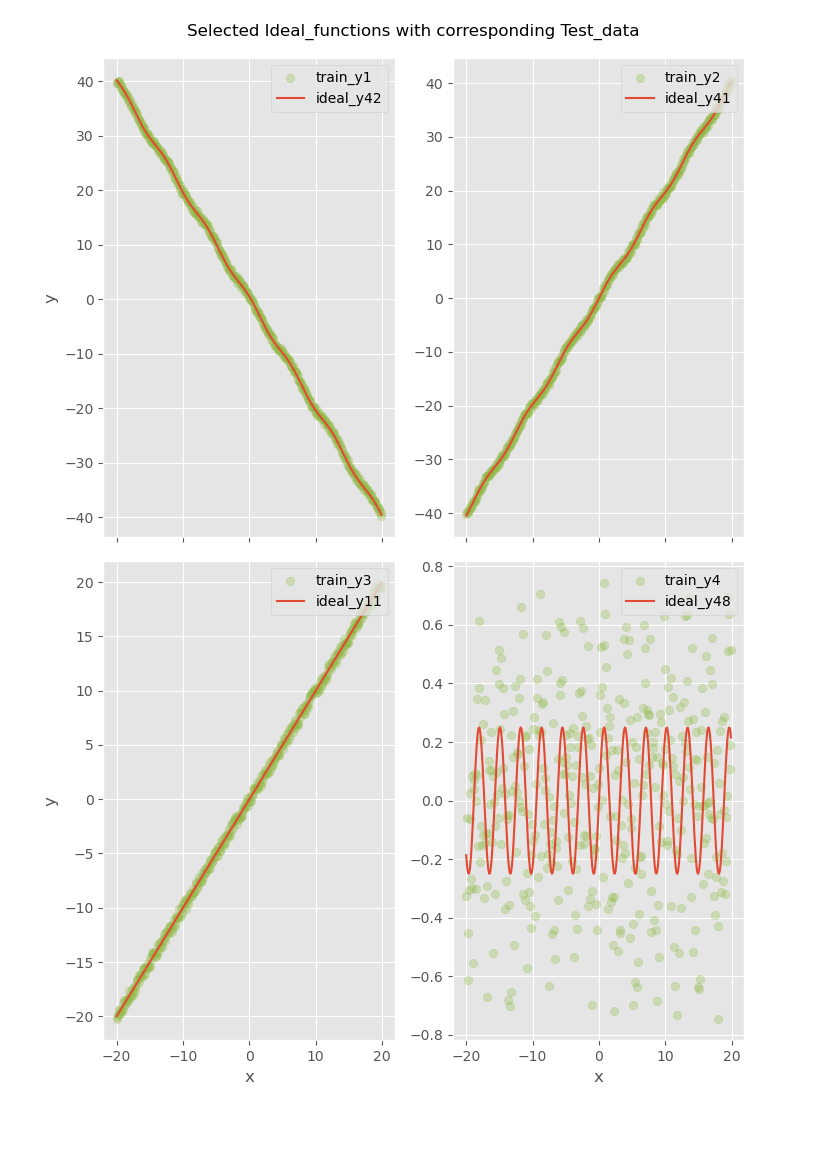

In [77]:
# # create graphs fitting ideal to train *4
x = train['x']

def plot_test_to_ideal(ideal_chosen, train):
    fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(8.27, 11.69), sharex=True)
    axis = fig.get_axes()
    color = Colors()
    
    plt.subplots_adjust(hspace=0.05, top=0.95) 
    fig.suptitle('Selected Ideal_functions with corresponding Test_data')
    
    # set lables
    for idx, ax in enumerate(axis):
        if idx>1:
            ax.set(xlabel='x')
        if idx%2==0:
            ax.set(ylabel='y')
            
    # plot graphs
    for ax, (train_name, train_data), (ideal_name, ideal_data) in zip(axis, train.iteritems(), ideal_chosen.iteritems()):
        ax.scatter(x=x, y=train_data, alpha=0.3, c='C5')
        ax.plot(x, ideal_data, c=color.next_color)
        ax.legend([f'train_{train_name}', f'ideal_{ideal_name}'], loc='upper right')
        
plot_test_to_ideal(ideal_chosen=ideal[chosen_ideal], train=train_lables)

In [24]:
merged_df = pd.merge(
    left=test.sort_values(by='x'),
    right=ideal[chosen_ideal + ['x']],
    how='left',
    on='x',
)
merged_df.head()

,x,y,y42,y41,y11,y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051


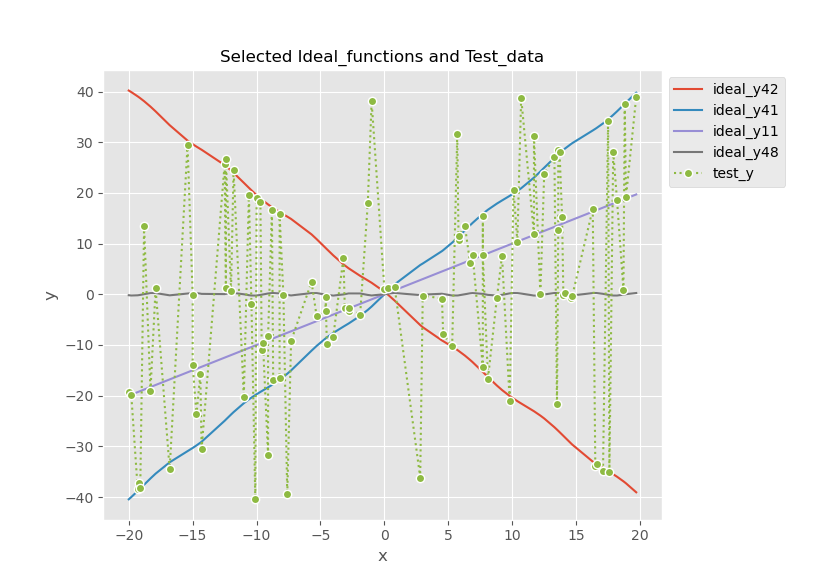

In [25]:
ax2 = merged_df.plot(x='x', 
                     y=chosen_ideal, 
                     ylabel='y', 
                     figsize=(8.27, 5.84)
                    )
ax2.set_title('Selected Ideal_functions and Test_data', fontsize=12)
ax2.plot(merged_df['x'], merged_df['y'], 'C5o:', mec='1.0')
labels = [f'ideal_{ch_i}' for ch_i in chosen_ideal] + ['test_y']
plt.subplots_adjust(right=0.8)
ax2.legend(labels=labels, loc='upper left', bbox_to_anchor=(1, 1))

In [26]:
ans = pd.Series(dtype=np.int32,
                name='amount of fitted points', 
                index=pd.Index([], name='ideal_func')
               )

for ideal_func in chosen_ideal:
    merged_df[f'div_{ideal_func}'] = np.absolute(merged_df['y'] - merged_df[ideal_func])
    ans[ideal_func] = sum(merged_df[f'div_{ideal_func}'] < __margin)
    
merged_df.head()

,x,y,y42,y41,y11,y48,div_y42,div_y41,div_y11,div_y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278,59.489010,21.171504,0.715030,19.098692
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503,59.805674,20.091822,0.115014,19.678511
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970,77.508697,0.359112,19.158572,38.262602
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224,76.040480,1.400790,17.970870,37.009646
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051,76.839778,0.168541,19.055376,38.035325


In [27]:
ans.to_frame().transpose()

ideal_func,y42,y41,y11,y48
amount of fitted points,21,26,26,18


# Creating CustomDF for final db

In [28]:
# final df init
test_mapped = pd.DataFrame(columns=['X (test func)', 'Y (test func)', 'Delta Y (test func)', 'No. of ideal func'])
idx = 0
nest_in_list = True #param

for i, row in merged_df.iterrows():
    # init row that will be implicted in df
    row_test_data = [row['x'].round(2), row['y']] # 1st and 2nd columns
    delta, No = list(), list() # 3rd and 4th columns
    
    for ideal_func_No, div in zip(chosen_ideal, row[chosen_ideal]):
        if abs(div - row['y']) < __margin:
            delta.append(round(abs(div - row['y']),6))
            No.append(ideal_func_No)
    # missing values case
    if not delta:
        delta = [pd.NA]
        No = [pd.NA]
    
    
    if nest_in_list:
        # covering into list multiple values
        if len(delta) > 1:
            delta = [delta]
            No = [No]
        test_mapped.loc[i] = row_test_data + delta + No
    else:
        # duplicate row with multiple fitting ideal_func datapoints
        for d, N in zip(delta, No):
            test_mapped.loc[idx] = row_test_data + [d, N]
            idx+=1

In [30]:
merged_df.head()

,x,y,y42,y41,y11,y48,div_y42,div_y41,div_y11,div_y48
0,-20.0,-19.284970,40.204040,-40.456474,-20.0,-0.186278,59.489010,21.171504,0.715030,19.098692
1,-19.8,-19.915014,39.890660,-40.006836,-19.8,-0.236503,59.805674,20.091822,0.115014,19.678511
2,-19.3,-38.458572,39.050125,-38.817684,-19.3,-0.195970,77.508697,0.359112,19.158572,38.262602
3,-19.2,-37.170870,38.869610,-38.571660,-19.2,-0.161224,76.040480,1.400790,17.970870,37.009646
4,-19.1,-38.155376,38.684402,-38.323917,-19.1,-0.120051,76.839778,0.168541,19.055376,38.035325


# Playing with inheritance from pd.df